In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from glob import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from network import ED, Decoder, Encoder
from torch.utils.data import DataLoader, Dataset
from params import (
    convlstm_encoder_params,
    convlstm_decoder_params,
)
import glob
from torchvision import transforms

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# PREDICTION

In [8]:
encoder = Encoder(convlstm_encoder_params[0], convlstm_encoder_params[1]).to(device)
decoder = Decoder(convlstm_decoder_params[0], convlstm_decoder_params[1]).to(device)
model = ED(encoder, decoder).to(device)

In [9]:
weights = torch.load("weights/lr_0.0005_b_4_e300_sd_1_prep _10_10_64/model/model.pth",map_location=device)
model.load_state_dict(weights)
model.eval()

print("Pesos cargados exitosamente.")

Pesos cargados exitosamente.


C:\Users\leons\AppData\Local\Temp\ipykernel_18476\1599273272.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("weights/lr_0.0005_b_4_e300_sd_1_prep _

In [10]:
# cargar datos

# Ruta a la carpeta donde están los archivos .npy
ruta_carpeta = "../data/precipitacion_interp_final/npy/*.npy"

# Obtener una lista con todos los archivos .npy en la carpeta
archivos_npy = sorted(glob.glob(ruta_carpeta))

# Cargar y concatenar los archivos en un solo array
arrays = [np.load(archivo) for archivo in archivos_npy]
array_concatenado = np.stack(arrays)

#elegir el numero de meses

months = 10
array_concatenado = array_concatenado[array_concatenado.shape[0]-months-1:-1,:,:]

# Imprimir la forma del array resultante
print("Forma del array concatenado:", array_concatenado.shape)


Forma del array concatenado: (10, 271, 221)


In [11]:
#resize

# Convertir a tensor de PyTorch
tensor = torch.from_numpy(array_concatenado).float()  # Convertir a float32

# Añadir el canal si es necesario (para imágenes en blanco y negro)
tensor = tensor.unsqueeze(1)  # Forma: (n, 1, filas, columnas)

# Crear la transformación usando transforms.Compose
resize_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Tamaño deseado
])

# Aplicar la transformación a cada imagen
tensor_resized = torch.stack([resize_transform(img) for img in tensor])

In [12]:
test_data = tensor_resized.squeeze(1)
test_data.shape

torch.Size([10, 64, 64])

In [13]:
new_test_data = test_data.unsqueeze(0).unsqueeze(2)
new_test_data.shape

torch.Size([1, 10, 1, 64, 64])

In [14]:
with torch.no_grad():
    output = model(new_test_data.to(device))  # Hidden states shape: (1, seq_length, 1, 64, 64)

In [15]:
future_predictions = output

In [16]:
# Crear la transformación usando transforms.Compose
resize_transform = transforms.Compose([
    transforms.Resize((271, 221)),  # Tamaño deseado
])

# Aplicar la transformación a cada imagen
tensor_resized = torch.stack([resize_transform(img) for img in future_predictions])

In [17]:
future_predictions = tensor_resized
future_predictions = tensor_resized.squeeze(0)
future_predictions = future_predictions.squeeze(1)
future_predictions.shape

torch.Size([10, 271, 221])

In [21]:
npy = future_predictions.cpu().numpy()
np.save("future_predictions.npy", npy)

(271, 221)


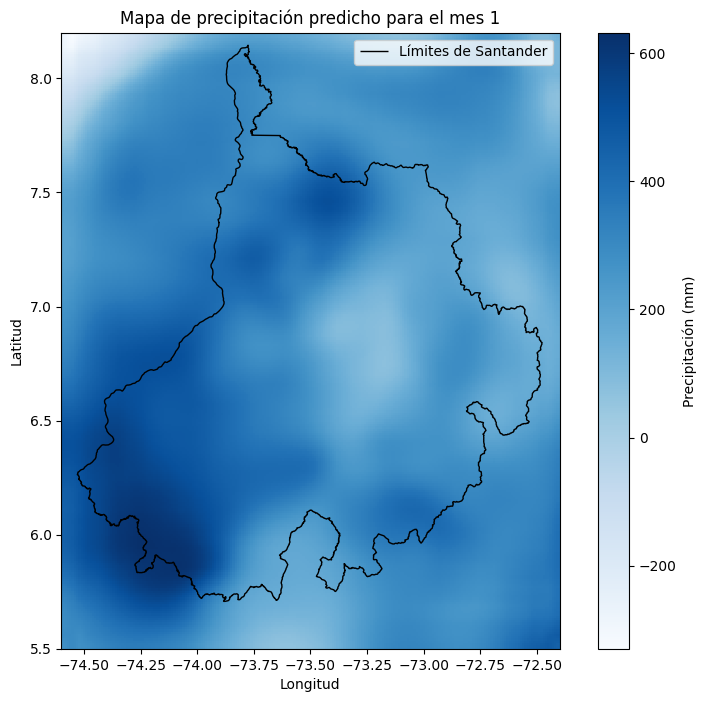

(271, 221)


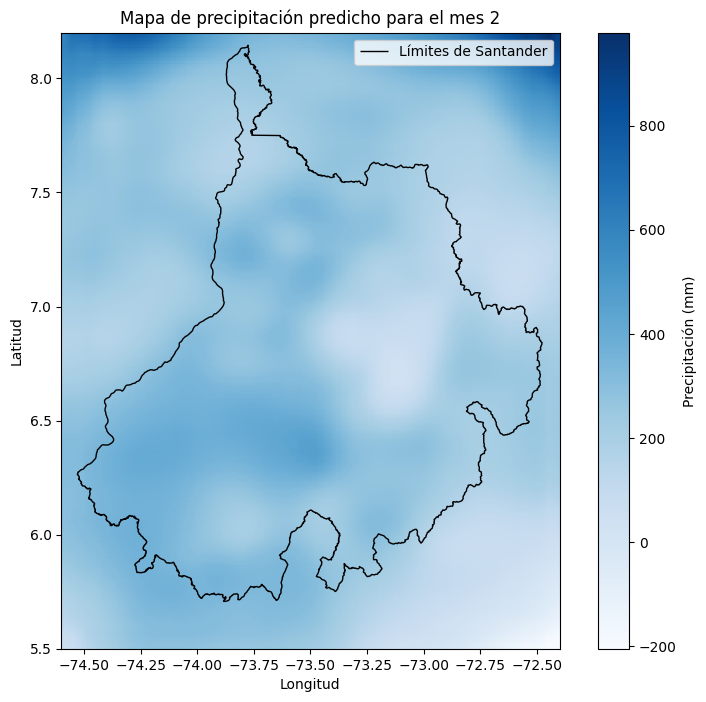

(271, 221)


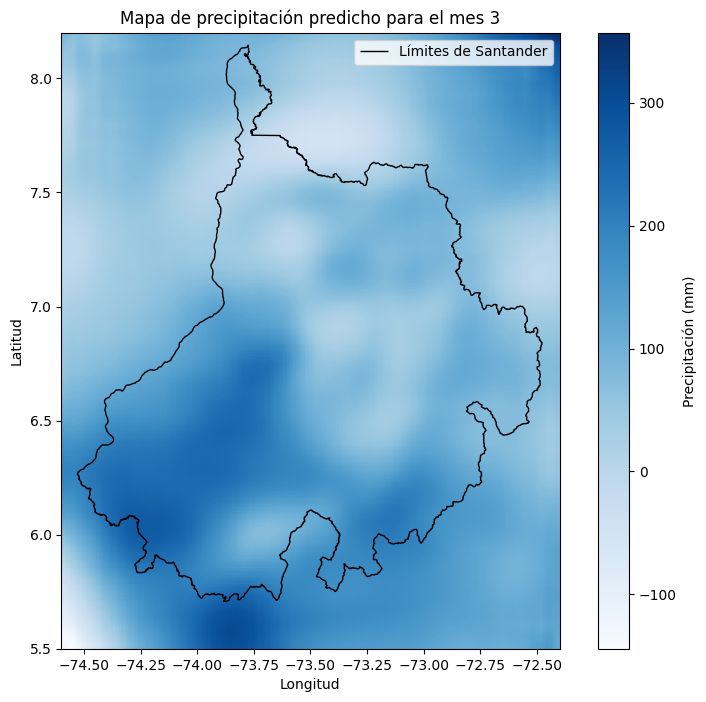

(271, 221)


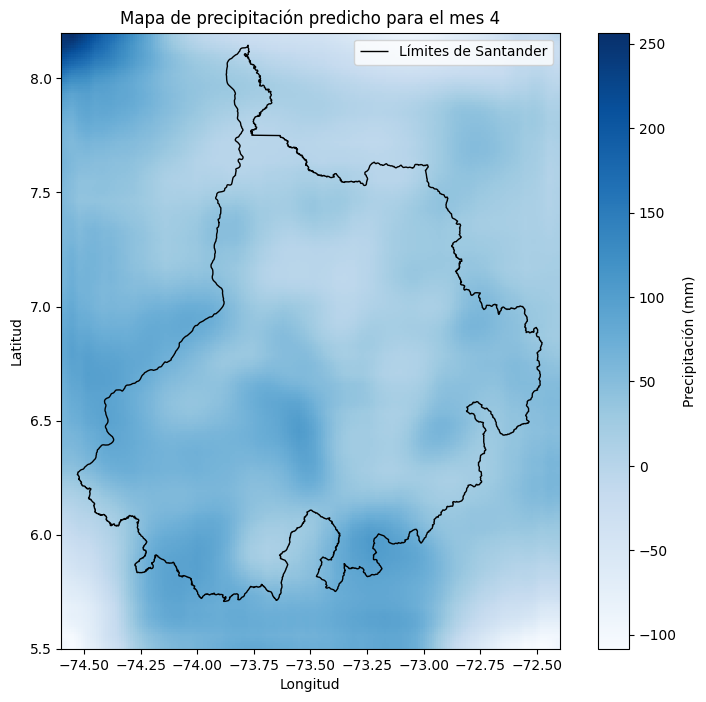

(271, 221)


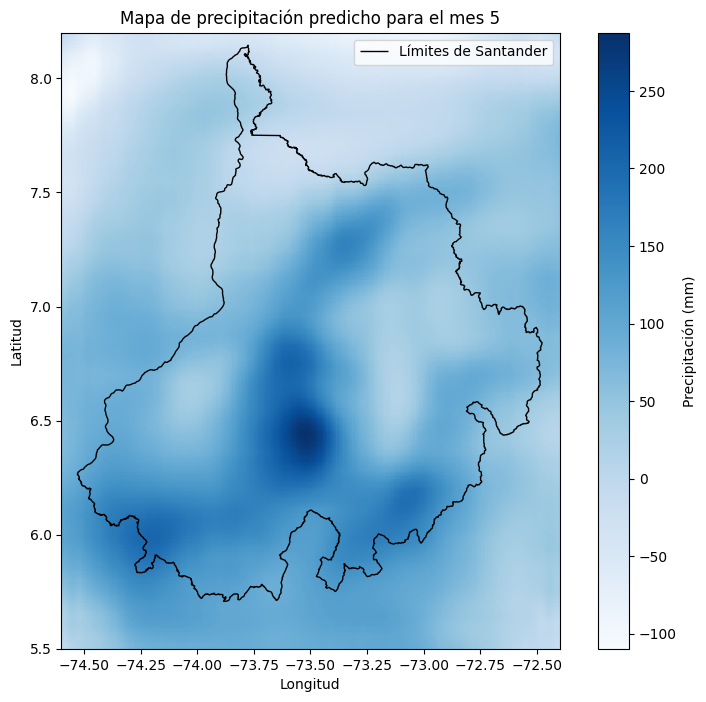

(271, 221)


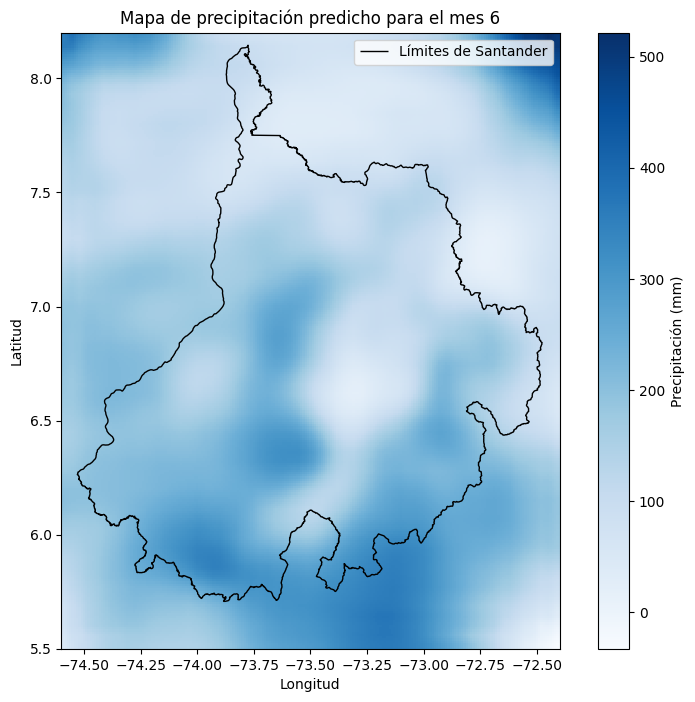

(271, 221)


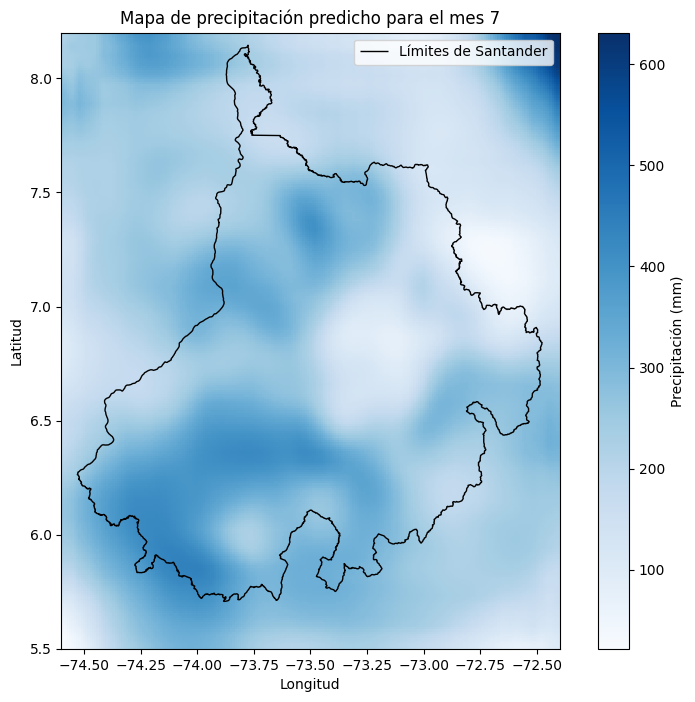

(271, 221)


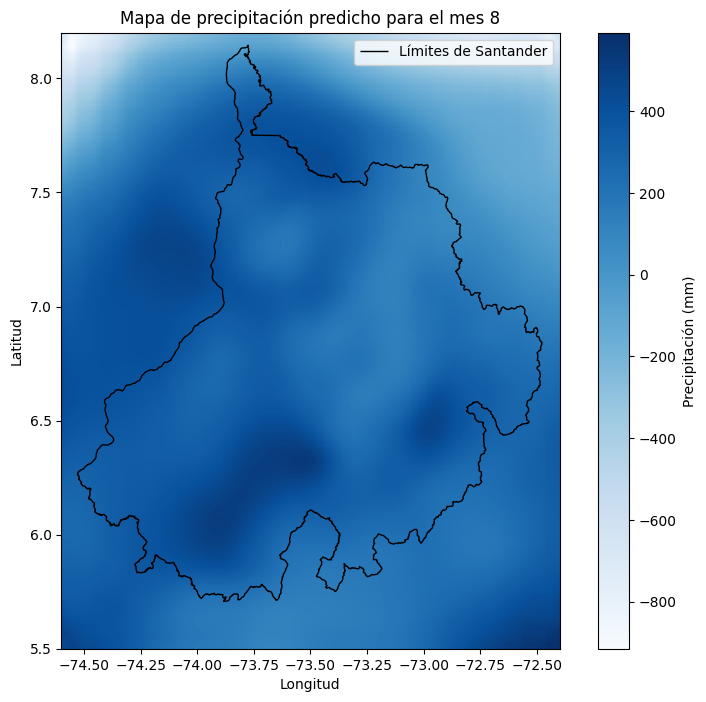

(271, 221)


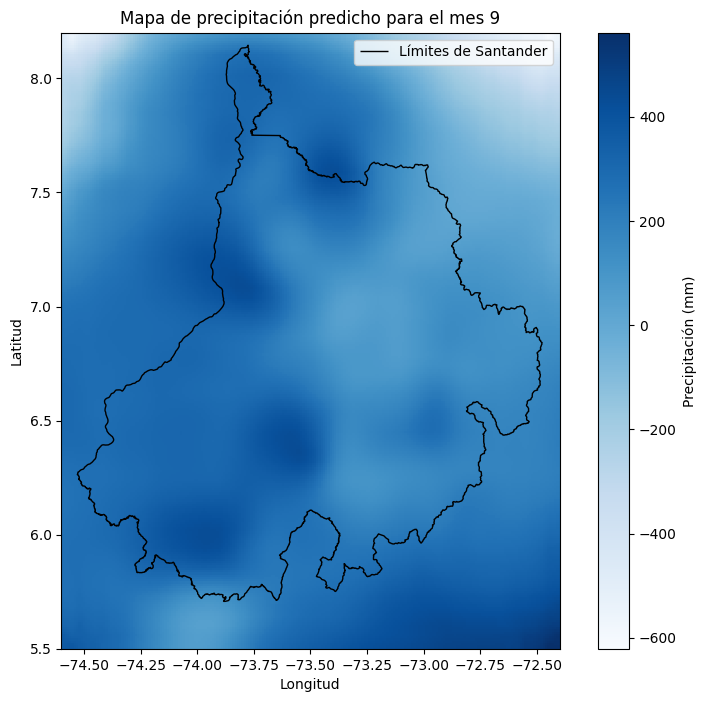

(271, 221)


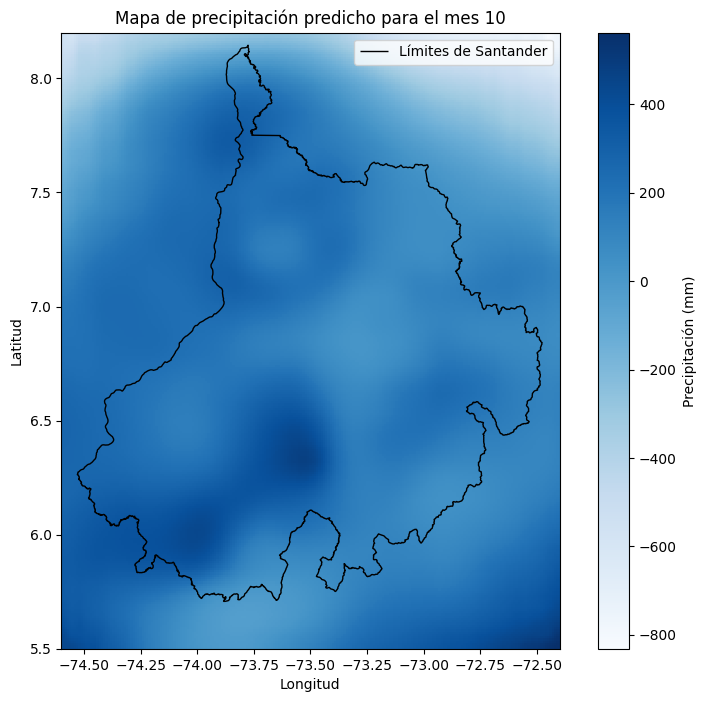

In [18]:
# Definir la región para limitar el gráfico
region = (-74.6, -72.4, 5.5, 8.2)

# Cargar el shapefile de los límites administrativos de Colombia
colombia_shapefile = '../data/aoi/Departamento.shp'
gdf = gpd.read_file(colombia_shapefile)

# Reproyectar a WGS84 si es necesario
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Filtrar para el departamento de Santander
santander_gdf = gdf[gdf['DeNombre'] == 'Santander']

# Crear las coordenadas de latitud y longitud para la grilla
latitudes = np.linspace(region[2], region[3], 271)
longitudes = np.linspace(region[0], region[1], 221)
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Iterar sobre cada mes predicho en `future_predictions`
for i, pred in enumerate(future_predictions):
    # Convertir la predicción del mes actual a numpy
    temperature_map = pred.cpu().numpy()  # Tiene forma (271, 221)
    print(temperature_map.shape)

    # Graficar la predicción de temperatura
    plt.figure(figsize=(10, 8))
    plt.pcolormesh(lon_grid, lat_grid, temperature_map, cmap='Blues', shading='auto')
    plt.colorbar(label='Precipitación (mm)')

    # Superponer los límites administrativos de Santander
    santander_gdf.boundary.plot(ax=plt.gca(), linewidth=1, edgecolor="black", label="Límites de Santander")

    # Limitar los ejes al área de interés
    plt.xlim(region[0], region[1])
    plt.ylim(region[2], region[3])

    # Etiquetas y título
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title(f'Mapa de precipitación predicho para el mes {i + 1}')
    plt.legend()
    plt.savefig(f'mapa_{i+1}', dpi=400, bbox_inches='tight')
    plt.show()


In [19]:
future_predictions.shape

torch.Size([10, 271, 221])

In [20]:
np.save('temperatura_2025-11-01.npy', future_predictions[9].cpu().numpy())